In [26]:
# Basic segmentation based on otsu
# Here the idea is to select sub-Roi and apply basic counting on each
# import sample data
import os
import skimage as ski
import os
from skimage import io

# Define the file path to the OME-TIFF file
file_path = "/Users/zg/Mammouth/PROJECTS/Analysis/Image_Choice/MAX_PMLwt_20_MMStack_Pos0.ome.tif"

# Read the OME-TIFF file
multi_channel_image = io.imread(file_path)

# Split the channels
# Assuming the image has two channels: 0 for nucleus and 1 for PML
Nucleus_PML = multi_channel_image[1, :, :]
PML = multi_channel_image[0, :, :]

# Verify the shapes of the images (for debugging purposes)
print(f"Nucleus image shape: {Nucleus_PML.shape}")
print(f"PML image shape: {PML.shape}")



Nucleus image shape: (1072, 1072)
PML image shape: (1072, 1072)


In [27]:
import napari
# create a `Viewer` and `Image` layer in Napari
viewer = napari.Viewer()
viewer.add_image(Nucleus_PML, colormap='blue', name='Nucleus PML')
viewer.add_image(PML, colormap='magma', name='PML')

<Image layer 'PML' at 0x16035d4c0>

In [28]:
#segmentation using otsu
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects

# apply threshold on PML bodies
thresh_PML = threshold_otsu(PML)
bw_PML = closing(PML > thresh_PML, square(5))

# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw_PML), 10)

# label image regions
label_image_PML = label(cleared)

# add the labels
labels_layer = viewer.add_labels(label_image_PML, name='segmentation-PML')

In [29]:
label_image_PML;


In [30]:
# apply threshold on Nucleus
thresh_Nuc = threshold_otsu(Nucleus_PML)
bw_Nuc = closing(Nucleus_PML > thresh_Nuc, square(13))

# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw_Nuc), 1500)

# label image regions
label_image_Nuc = label(cleared)

# add the labels
labels_layer = viewer.add_labels(label_image_Nuc, name='segmentation-Nucleus')
viewer.add_image(Nucleus_PML, colormap='magma', name='Nuc')

<Image layer 'Nuc' at 0x160286660>

In [31]:
Mask=viewer.layers[2].data

In [32]:
Result_PML=Mask*PML; #unclear if it is required
viewer.add_image(Result_PML)

<Image layer 'Result_PML' at 0x166c05850>

In [33]:
# Here is the generalized version 
import numpy as np
import napari
# Assuming you have loaded your Nucleus_PML image into Nucleus_PML

# Get unique label values from the label image
unique_labels = np.unique(label_image_Nuc)

# Remove background label if exists
unique_labels = unique_labels[unique_labels != 0]

# Initialize a list to store extracted ROIs and corresponding results
roi_list = []
result_list = []

# Extract each ROI by its label value and perform desired operation (multiplication with Nucleus_PML in this case)
for label in unique_labels:
    # Extract the ROI with the current label value
    roi = np.where(label_image_Nuc == label, 1, 0)
    roi_list.append(roi)
    
    # Perform desired operation on the ROI (e.g., multiplication with Nucleus_PML)
    result_roi = Nucleus_PML * roi
    result_list.append(result_roi)

# Display each extracted ROI and result using napari
viewer = napari.Viewer()
for i, (roi, result_roi) in enumerate(zip(roi_list, result_list)):
    viewer.add_image(roi, name=f'ROI_{unique_labels[i]}')
    viewer.add_image(result_roi, name=f'Result_ROI_{unique_labels[i]}')

#napari.run()

        area  mean_intensity_x  nucleus  occurrence  mean_area  \
0   0.167710       2202.062500        1           7   0.554041   
1   0.566020       3148.611111        1           7   0.554041   
2   0.702285       3175.626866        1           7   0.554041   
3   0.754694       3487.069444        1           7   0.554041   
4   0.744212       3279.394366        1           7   0.554041   
5   0.754694       2336.291667        1           7   0.554041   
6   0.188673       2377.222222        1           7   0.554041   
7   0.482166       2292.760870        3           3   0.593972   
8   0.597466       2982.421053        3           3   0.593972   
9   0.702285       3238.432836        3           3   0.593972   
10  1.194932       3131.166667        4           4   0.746832   
11  0.503129       3398.520833        4           4   0.746832   
12  0.576502       2156.472727        4           4   0.746832   
13  0.712766       2664.044118        4           4   0.746832   
14  0.1362

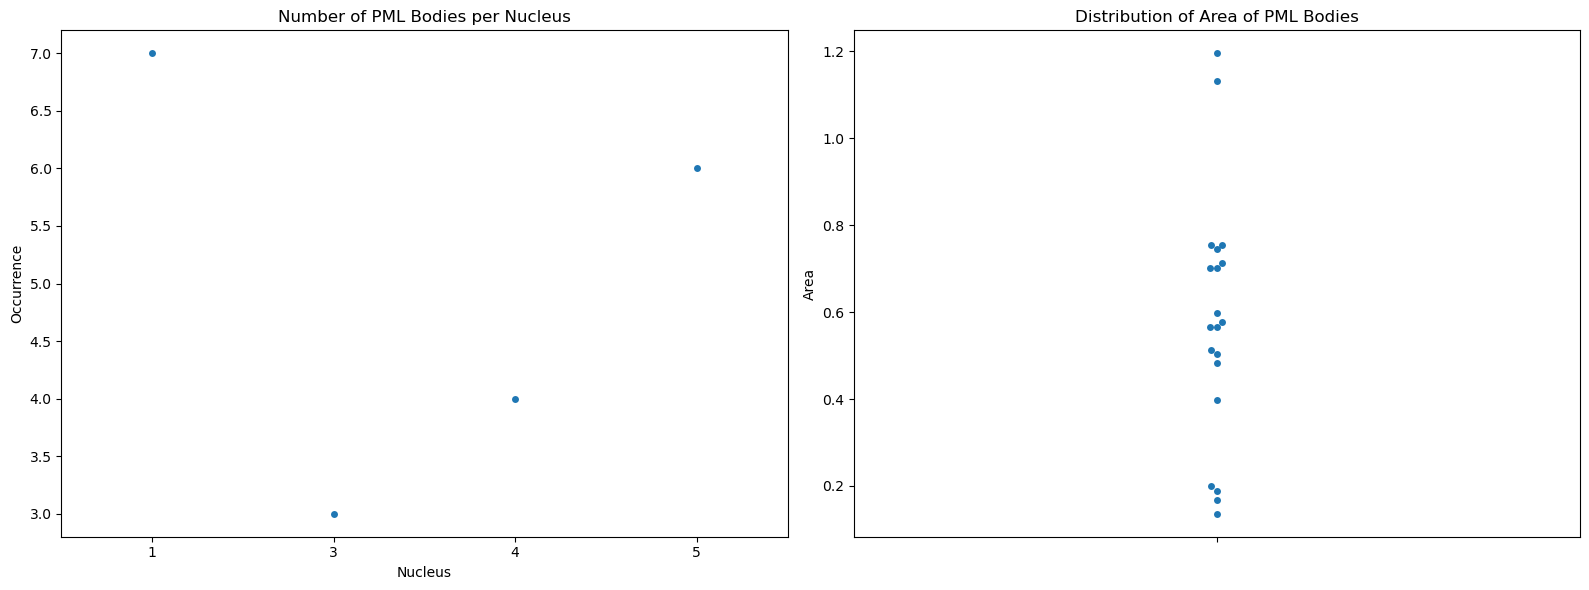

In [38]:
from skimage import measure
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Assuming you have loaded your label image into label_image_Nuc

# Get unique label values from the label image
unique_labels = np.unique(label_image_Nuc)

# Remove background label if exists
unique_labels = unique_labels[unique_labels != 0]

# Initialize final_result Data Frame
final_result=pd.DataFrame()

# Extract each ROI by its label value and calculate region properties
for label in unique_labels:
    # Extract the ROI with the current label value
    roi = np.where(label_image_Nuc == label, 1, 0)
    
    # Calculate the product with the PML intensity image
    Product= roi*label_image_PML
    
    # Measure region properties
    region_properties = measure.regionprops_table(Product, PML, properties=['area', 'mean_intensity'])
    
    # Create a DataFrame for the current region properties
    df=pd.DataFrame(region_properties)
    
    # Add the nucleus label to the DataFrame
    df['nucleus']=label
    
    # Append the current DataFrame to the final result
    final_result=pd.concat([final_result,df])
    
# Define the pixel size and calculate the pixel area
pix_size=6.45/63;
pix_size_square = pix_size ** 2;

# Multiply the 'area' column by the pixel size squared
final_result['area'] = final_result['area'] * pix_size_square

# Group by 'nucleus' and calculate the required statistics
grouped = final_result.groupby('nucleus').agg(
    occurrence=('nucleus', 'size'),           # Count the number of entries for each nucleus
    mean_area=('area', 'mean'),               # Calculate the mean area for each nucleus
    mean_intensity=('mean_intensity', 'mean') # Calculate the mean intensity for each nucleus
).reset_index()

# Merge the statistics back into the final_result DataFrame
final_result = pd.merge(final_result, grouped, on='nucleus', how='left')

# Print the final result
print(final_result)

# Create side-by-side swarmplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the number of PML bodies per nucleus
sns.swarmplot(data=grouped, y='occurrence',x='nucleus', ax=axes[0])
axes[0].set_title('Number of PML Bodies per Nucleus')
axes[0].set_ylabel('Occurrence')
axes[0].set_xlabel('Nucleus')

# Plot the distribution of area of the entire population of PML bodies
sns.swarmplot(data=final_result, y='area', ax=axes[1])
axes[1].set_title('Distribution of Area of PML Bodies')
axes[1].set_ylabel('Area')
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

In [34]:
#The function final_result.groupby('nucleus').count() is used to group the rows of the DataFrame final_result by the values in the 'nucleus' column and then count the number of occurrences for each group. 
final_result.groupby('nucleus').count()

,area,mean_intensity_x,occurrence,mean_area,mean_intensity_y
nucleus,,,,,
1,7,7,7,7,7
3,3,3,3,3,3
4,4,4,4,4,4
5,6,6,6,6,6


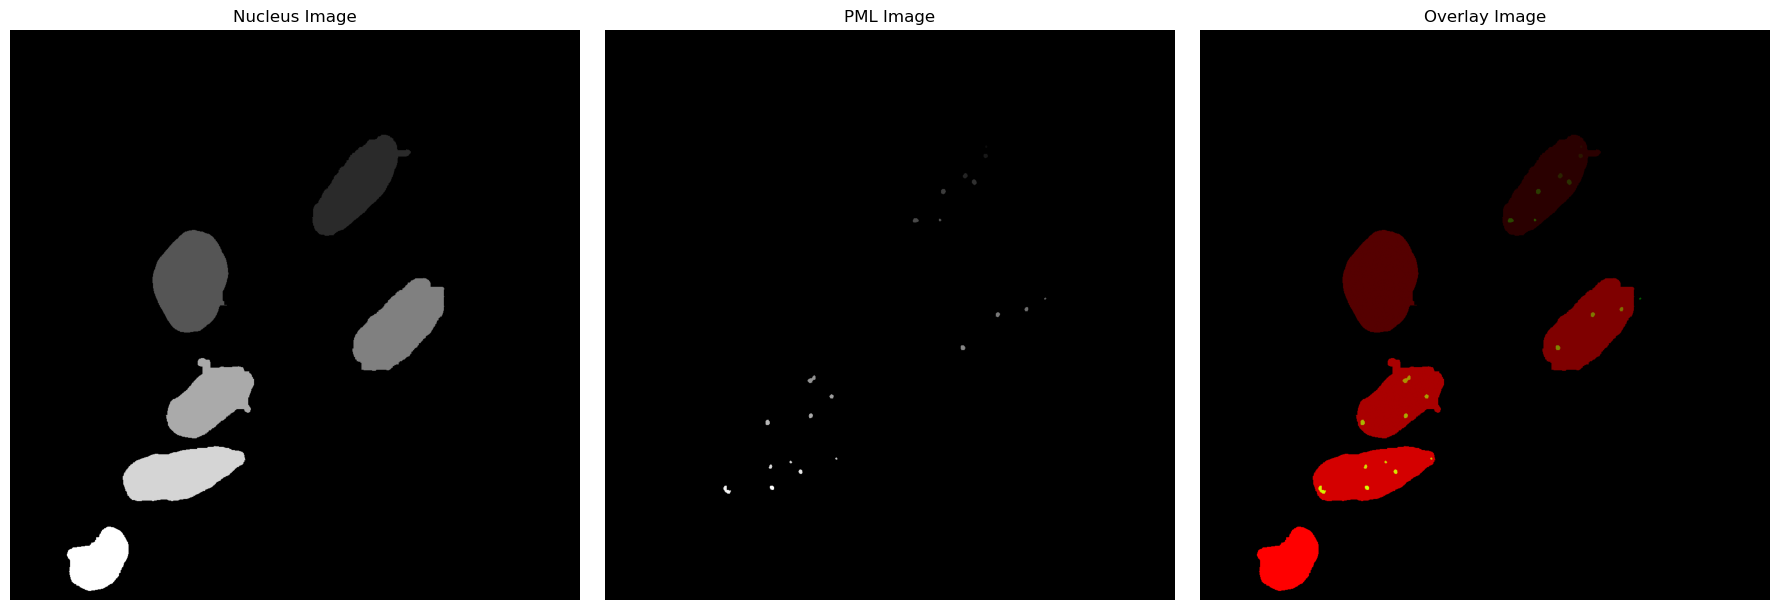

In [40]:
from skimage import io, img_as_float
from skimage.color import gray2rgb

# Assuming label_image_Nuc and label_image_PML are the images you want to overlay
# For this example, let's assume these images are already loaded as numpy arrays

# Convert the images to float type for proper overlay
nucleus_image = img_as_float(label_image_Nuc)
pml_image = img_as_float(label_image_PML)

# Normalize the images to the range [0, 1]
nucleus_image = (nucleus_image - nucleus_image.min()) / (nucleus_image.max() - nucleus_image.min())
pml_image = (pml_image - pml_image.min()) / (pml_image.max() - pml_image.min())

# Convert grayscale images to RGB
nucleus_rgb = gray2rgb(nucleus_image)
pml_rgb = gray2rgb(pml_image)

# Create an overlay image
# Assuming you want nucleus in red and PML in green
overlay_image = nucleus_rgb.copy()
overlay_image[..., 0] = nucleus_image  # Red channel
overlay_image[..., 1] = pml_image      # Green channel
overlay_image[..., 2] = 0              # Blue channel remains 0

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(nucleus_image, cmap='gray')
axes[0].set_title('Nucleus Image')
axes[0].axis('off')

axes[1].imshow(pml_image, cmap='gray')
axes[1].set_title('PML Image')
axes[1].axis('off')

axes[2].imshow(overlay_image)
axes[2].set_title('Overlay Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()